# Coordinate-based meta-regression algorithms

A tour of CBMR algorithms in NiMARE
This tutorial is intended to provide a brief description and example of the CBMR algorithm implemented in NiMARE. For a more detailed introduction to the elements of a coordinate-based meta-regression, see other stuff.

In [2]:
from nimare.utils import get_masker, B_spline_bases, dummy_encoding_moderators, get_resource_path,index2vox
from nimare.tests.utils import standardize_field
from nimare.meta import models

from nilearn.plotting import plot_stat_map
from nimare.generate import create_coordinate_dataset
import nibabel as nib

import numpy as np
import scipy
import logging
import sys

## Load Dataset

In [3]:
# data simulation
ground_truth_foci, dset = create_coordinate_dataset(foci=10, sample_size=(20, 40), n_studies=1000)
# set up group columns: diagnosis & drug_status  
n_rows = dset.annotations.shape[0]
dset.annotations['diagnosis'] = ["schizophrenia" if i%2==0 else 'depression' for i in range(n_rows)]
dset.annotations['drug_status'] = ['Yes' if i%2==0 else 'No' for i in range(n_rows)]
dset.annotations['drug_status'] = dset.annotations['drug_status'].sample(frac=1).reset_index(drop=True) # random shuffle drug_status column
# set up moderators: sample sizes & avg_age
dset.annotations["sample_sizes"] = [dset.metadata.sample_sizes[i][0] for i in range(n_rows)] 
dset.annotations["avg_age"] = np.arange(n_rows)
dset.annotations['schizophrenia_subtype'] = ["type1", "type2", "type3", "type4", "type5"] * int(n_rows/5)
# dset.annotations['schizophrenia_subtype'] = ['type1' if i%2==0 else 'type2' for i in range(n_rows)]
dset.annotations['schizophrenia_subtype'] = dset.annotations['schizophrenia_subtype'].sample(frac=1).reset_index(drop=True) # random shuffle drug_status column


# Estimate group-specific spatial intensity function 

In [5]:
from nimare.meta.cbmr import CBMREstimator
dset = standardize_field(dataset=dset, metadata=["sample_sizes", "avg_age", "schizophrenia_subtype"])
cbmr = CBMREstimator(
    group_categories=["diagnosis", "drug_status"],
    moderators=["standardized_sample_sizes", "standardized_avg_age", "schizophrenia_subtype"],
    spline_spacing=10,
    model=models.PoissonEstimator,
    penalty=False,
    lr=1e-1,
    tol=1e4,
    device="cpu"
)
cres = cbmr.fit(dataset=dset)
plot_stat_map(
    cres.get_map("Group_schizophrenia_Yes_Studywise_Spatial_Intensity"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r"
)
plot_stat_map(
    cres.get_map("Group_schizophrenia_No_Studywise_Spatial_Intensity"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r"
)
plot_stat_map(
    cres.get_map("Group_depression_Yes_Studywise_Spatial_Intensity"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r"
)
plot_stat_map(
    cres.get_map("Group_depression_No_Studywise_Spatial_Intensity"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r"
)


INFO:nimare.diagnostics:0/10000 coordinates fall outside of the mask. Removing them.


In [7]:
cres.maps.keys()

dict_keys(['Group_schizophrenia_Yes_Studywise_Spatial_Intensity', 'Group_depression_Yes_Studywise_Spatial_Intensity', 'Group_schizophrenia_No_Studywise_Spatial_Intensity', 'Group_depression_No_Studywise_Spatial_Intensity'])

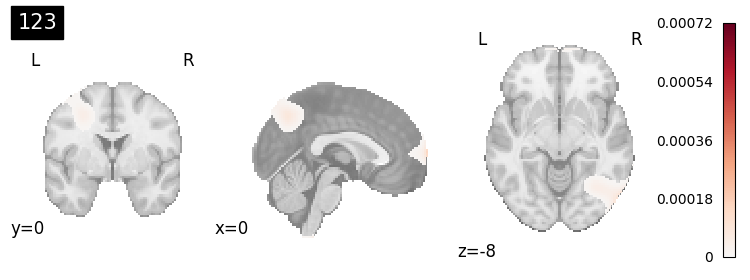

In [10]:
plot_stat_map(
    cres.get_map("Group_schizophrenia_Yes_Studywise_Spatial_Intensity"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    threshold=1e-5,
)